In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Part I: Breast Cancer Dataset

In the previous assignments, we looked at the breast cancer dataset, where we attempted to identify whether a tumour is malignant or benign - to then be able to treat it correctly. We understood that accuracy was probably not a accurate representation of any classification model, as we would want to make sure that we treated positive cases and not negative cases, likewise, and more importantly, catching all the positive cases. Therefore, precision and recall were better suited metrics to assess the binary classification model.

In this assignment, we revisit this dataset, with the same goals in mind. A logistic regression and decision tree model will be fitted to predict the tumour status. Additionally, we aim to also find the importance of cell nucleus features, and we can do this using Principal Component Analysis (PCA).

**Loading in the Dataset**

In [4]:
breast_cancer = pd.read_csv('../datasets/breast-cancer.csv', sep=',')

In [5]:
# Quick look at the dataframe
breast_cancer.head(5)

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883


A glance at the dataframe shows us the diagnosis (prediction variable) and the other 10 features. Additionally, we can remove the id column, as it is not useful in our model. Likewise, it is good practice to inspect any anomaly or invalid cases in the data before modelling.

In [6]:
# drop the id column
breast_cancer = breast_cancer.drop('id', axis=1)

In [7]:
# Check for any missing values in the dataset
null_count = np.array(breast_cancer.isnull().sum())
na_counts = np.array(breast_cancer.isna().sum())
pd.DataFrame(np.vstack((null_count, na_counts)), columns=breast_cancer.columns, index=['null_count','na_counts'])

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean
null_count,0,0,0,0,0,0,0,0,0,0,0
na_counts,0,0,0,0,0,0,0,0,0,0,0


In [8]:
breast_cancer.describe()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440


We can tell that the data looks quite okay. However, we can see that a particular feature (area_mean) has much higher values compared to the other features, and variance is much larger as well. 

No null or invalid values, which is good.

With all machine learning algorithms, we first need to seperate the dataset into training and test sets. We use a 85/15 split.

In [9]:
from sklearn.model_selection import train_test_split

X = breast_cancer.iloc[:,1:11]
y = breast_cancer.iloc[:,0]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=5508)

In [10]:
# Inspect the dimensions of the training and test sets, for both y and x 
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((483, 10), (483,), (86, 10), (86,))

**1. Logistc Regression**

In this section, we build a logistic regression model on the training set to predict tumour status. Additionally, we want to find the optimal hyperparameters that we achieve the best model. We first start of with the base model with no hyperparameters.

In [11]:
from sklearn.linear_model import LogisticRegression

bc_logreg_base = LogisticRegression(random_state=5508, max_iter=10000)
bc_logreg_base.fit(X_train.values, y_train)

LogisticRegression(max_iter=10000, random_state=5508)

In [12]:
from sklearn.metrics import confusion_matrix,  ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.metrics import classification_report

# Start by evaluating the model on the training set
y_train_pred = bc_logreg_base.predict(X_train.values)
y_test_pred = bc_logreg_base.predict(X_test.values)
target_names = bc_logreg_base.classes_

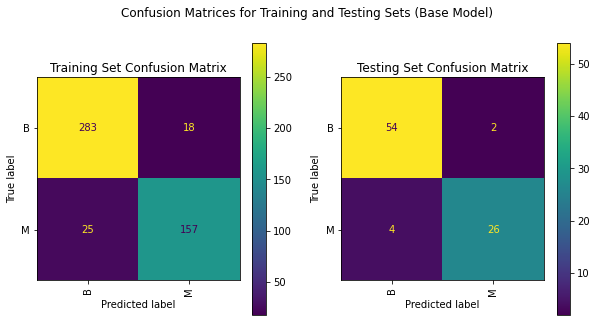

In [47]:
# Function to display the confusion matrix for the training and testing sets
def display_confusion_matrix(y_train, y_test, y_train_pred, y_test_pred, target_names, model_name):
    test_cm = confusion_matrix(y_test, y_test_pred)
    disp_test = ConfusionMatrixDisplay(confusion_matrix=test_cm, display_labels=target_names)
    train_cm = confusion_matrix(y_train, y_train_pred)
    disp_train = ConfusionMatrixDisplay(confusion_matrix=train_cm, display_labels=target_names)
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].set_title('Training Set Confusion Matrix')
    disp_train.plot(ax=axs[0], xticks_rotation='vertical')
    axs[1].set_title('Testing Set Confusion Matrix')
    disp_test.plot(ax=axs[1], xticks_rotation='vertical')
    fig.suptitle(f'Confusion Matrices for Training and Testing Sets ({model_name})')
    plt.show()
    
# Base Model Confusion Matrix for 2 class benign/malignant classification
display_confusion_matrix(y_train, y_test, y_train_pred, y_test_pred, target_names, 'Base Model')

In [14]:
# Classification report
def summarize_classification(y_train, y_test, y_train_pred, y_test_pred, target_names):
    print('Training Set Report:')
    print(classification_report(y_train, y_train_pred, target_names=target_names))
    print('Testing Set Report:')
    print(classification_report(y_test, y_test_pred, target_names=target_names))

summarize_classification(y_train, y_test, y_train_pred, y_test_pred, target_names)

Training Set Report:
              precision    recall  f1-score   support

           B       0.92      0.94      0.93       301
           M       0.90      0.86      0.88       182

    accuracy                           0.91       483
   macro avg       0.91      0.90      0.90       483
weighted avg       0.91      0.91      0.91       483

Testing Set Report:
              precision    recall  f1-score   support

           B       0.93      0.96      0.95        56
           M       0.93      0.87      0.90        30

    accuracy                           0.93        86
   macro avg       0.93      0.92      0.92        86
weighted avg       0.93      0.93      0.93        86



From the above model predictions and performance metrics, we can see that our base model might not be the best at catching the malignant tumors. The recall parameter tells us the number of classified positive cases as a proportion of true positive cases. This metric is important for both catching the malignant tumors accurately. The precision parameter is more important to catching the benign tumors as we do not want to misclassify them and treat them using malignant treatments.

We continue to find the best model using hyperparameter tuning and then cross-validation.

In [27]:
# Hyperparameter tuning for logistic regression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, precision_score, recall_score
from sklearn.model_selection import cross_validate

# grid of hyperparameters to search
param_grid = {'C': [0.001, 0.01, 0.1, 1, 5, 10, 100],
                'penalty': ['l1', 'l2'],
                'solver': ['liblinear','saga'],}

bc_logreg_cv = GridSearchCV(bc_logreg_base, param_grid, cv=5, scoring = make_scorer(recall_score, pos_label='M'), n_jobs=-1)
# Fit to the training data
bc_logreg_cv.fit(X_train.values, y_train)

GridSearchCV(cv=5,
             estimator=LogisticRegression(max_iter=10000, random_state=5508),
             n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 5, 10, 100],
                         'penalty': ['l1', 'l2'],
                         'solver': ['liblinear', 'saga']},
             scoring=make_scorer(recall_score, pos_label=M))

Upon using the Grid Search CV, we can look at the best hyperparameters that gives us the best recall score on Malignant instances.

In [28]:
bc_logreg_cv.best_params_

{'C': 100, 'penalty': 'l1', 'solver': 'liblinear'}

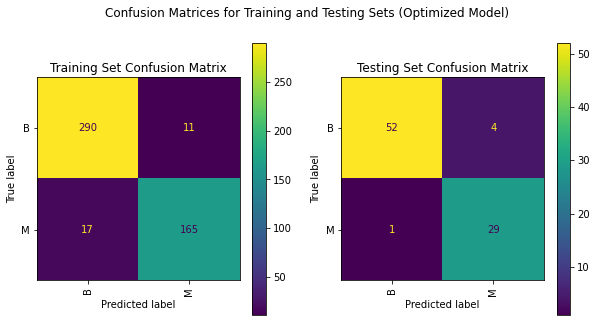

Training Set Report:
              precision    recall  f1-score   support

           B       0.94      0.96      0.95       301
           M       0.94      0.91      0.92       182

    accuracy                           0.94       483
   macro avg       0.94      0.94      0.94       483
weighted avg       0.94      0.94      0.94       483

Testing Set Report:
              precision    recall  f1-score   support

           B       0.98      0.93      0.95        56
           M       0.88      0.97      0.92        30

    accuracy                           0.94        86
   macro avg       0.93      0.95      0.94        86
weighted avg       0.95      0.94      0.94        86



In [48]:
# Best model
bc_logreg_best = bc_logreg_cv.best_estimator_
bc_logreg_best.fit(X_train.values, y_train)

y_train_best = bc_logreg_best.predict(X_train.values)
y_test_best = bc_logreg_best.predict(X_test.values)

display_confusion_matrix(y_train, y_test, y_train_best, y_test_best, target_names, 'Optimized Model')
summarize_classification(y_train, y_test, y_train_best, y_test_best, target_names)

The recall scores on the malignant observations have increased substantially as compared to the base model, this is exactly what we were after. However, to acertain that our new logistic regression model with the optimal hyperparameters is much better than the base model, we can use k-fold cross validation using k=5. 

In [32]:
# Cross Validation, prepare the scorers on each class
scorers = {
    'precision': make_scorer(precision_score, pos_label='B'),
    'recall': make_scorer(recall_score, pos_label='M')
}

def cross_validation(model, X_train, y_train, cv=5):
    cv_scores = cross_validate(model, X_train, y_train, cv=cv, scoring=scorers)
    return cv_scores
    
cv_scores_base = cross_validation(bc_logreg_base, X_train, y_train, cv=5)
cv_scores_best = cross_validation(bc_logreg_best, X_train, y_train, cv=5)

In [38]:
print(f"Base Model Precision: {cv_scores_base['test_precision'].mean()}, Recall: {cv_scores_base['test_recall'].mean()}")
print(f"Optimal Model Precision: {cv_scores_best['test_precision'].mean()}, Recall: {cv_scores_best['test_recall'].mean()}")

Base Model Precision: 0.9133039967077787, Recall: 0.8515015015015015
Optimal Model Precision: 0.9423615612306628, Recall: 0.9012012012012012


**Decision Tree Classifier**

In the second part of the classification prediction, we would like to achieve the same goals, but this time using a decision tree classsifier.